In [124]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

# Plotly Libraries

%matplotlib inline
import matplotlib
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (9, 9)

from plotly import express as px, graph_objects as go
from plotly.subplots import make_subplots
from IPython.core.pylabtools import figsize

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import BayesianRidge,LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import RBF,DotProduct,ConstantKernel,RationalQuadratic, ExpSineSquared, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import metrics

# PyMC3 for Bayesian Inference
import pymc3 as pm

In [125]:
#Reading the csv file

co2_vehicles= pd.read_csv('CO2_Emissions.csv')
df=co2_vehicles.copy()
df.head(5)

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [127]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Engine Size(L),7385.0,3.160068,1.354170,0.9,2.0,3.0,3.7,8.4
Cylinders,7385.0,5.615030,1.828307,3.0,4.0,6.0,6.0,16.0
Fuel Consumption City (L/100 km),7385.0,12.556534,3.500274,4.2,10.1,12.1,14.6,30.6
Fuel Consumption Hwy (L/100 km),7385.0,9.041706,2.224456,4.0,7.5,8.7,10.2,20.6
Fuel Consumption Comb (L/100 km),7385.0,10.975071,2.892506,4.1,8.9,10.6,12.6,26.1
Fuel Consumption Comb (mpg),7385.0,27.481652,7.231879,11.0,22.0,27.0,32.0,69.0
CO2 Emissions(g/km),7385.0,250.584699,58.512679,96.0,208.0,246.0,288.0,522.0


In [128]:
df['Vehicle Class'].unique()

array(['COMPACT', 'SUV - SMALL', 'MID-SIZE', 'TWO-SEATER', 'MINICOMPACT',
       'SUBCOMPACT', 'FULL-SIZE', 'STATION WAGON - SMALL',
       'SUV - STANDARD', 'VAN - CARGO', 'VAN - PASSENGER',
       'PICKUP TRUCK - STANDARD', 'MINIVAN', 'SPECIAL PURPOSE VEHICLE',
       'STATION WAGON - MID-SIZE', 'PICKUP TRUCK - SMALL'], dtype=object)

In [129]:
df['Model'].unique()

array(['ILX', 'ILX HYBRID', 'MDX 4WD', ...,
       'Tacoma 4WD D-Cab TRD Off-Road/Pro', 'Atlas Cross Sport 4MOTION',
       'XC40 T4 AWD'], dtype=object)

In [130]:
# Split Gears from Transmission Column

df["Gears"]=  df['Transmission'].str.extract('(\d+)')
df["Gears"] = df["Gears"].fillna(0)
df["Gears"] = pd.to_numeric(df["Gears"])

df['Transmission']=df['Transmission'].str.replace('\d+', '')
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Gears
0,ACURA,ILX,COMPACT,2.0,4,AS,Z,9.9,6.7,8.5,33,196,5
1,ACURA,ILX,COMPACT,2.4,4,M,Z,11.2,7.7,9.6,29,221,6
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV,Z,6.0,5.8,5.9,48,136,7
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS,Z,12.7,9.1,11.1,25,255,6
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS,Z,12.1,8.7,10.6,27,244,6


C:\Users\jobis\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


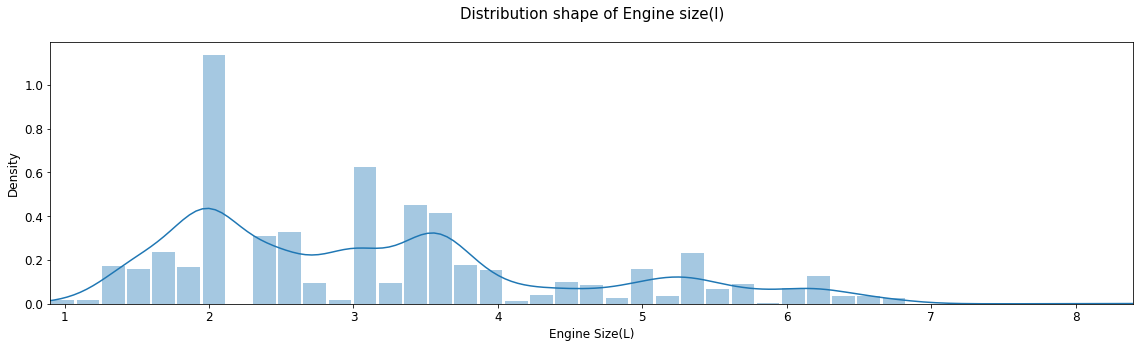

C:\Users\jobis\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


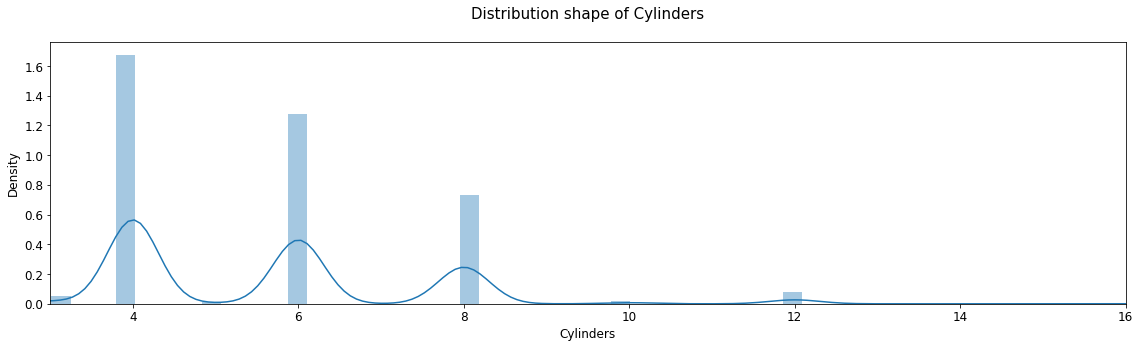

C:\Users\jobis\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


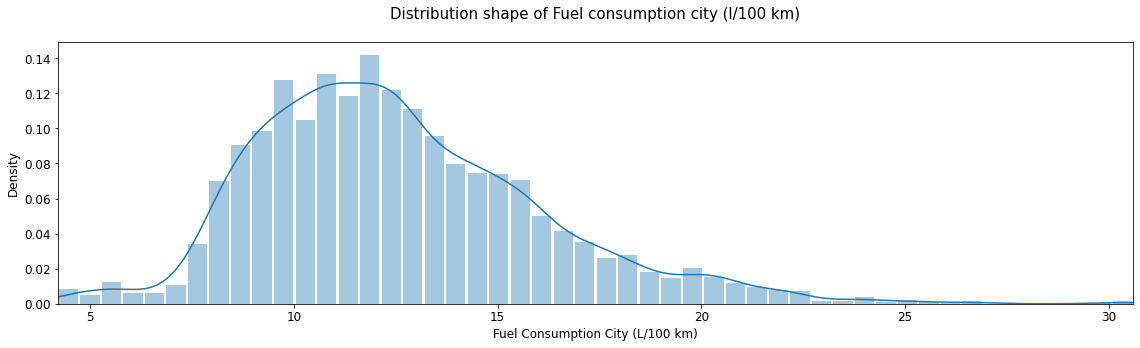

C:\Users\jobis\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


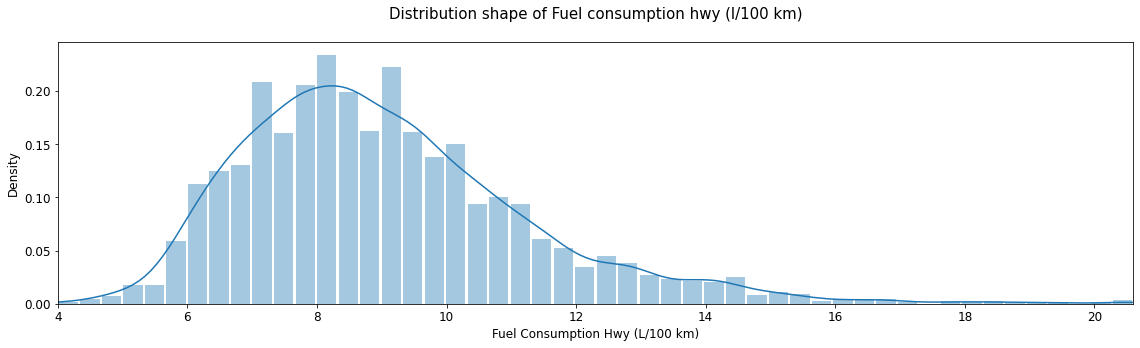

C:\Users\jobis\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


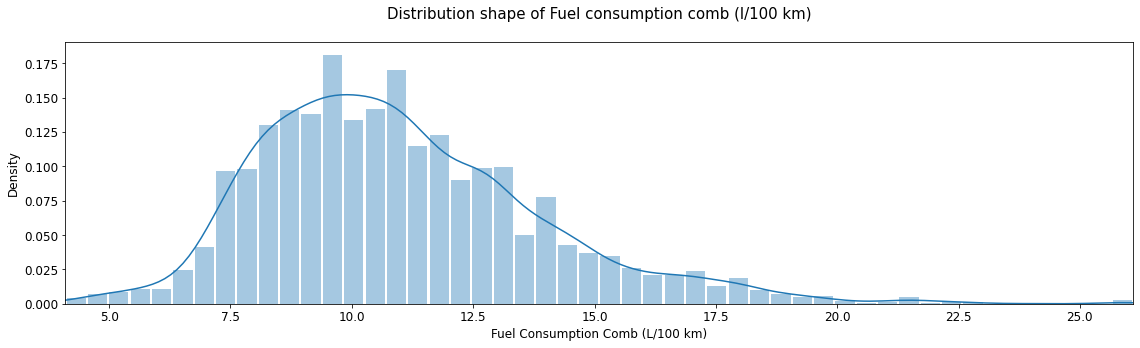

C:\Users\jobis\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


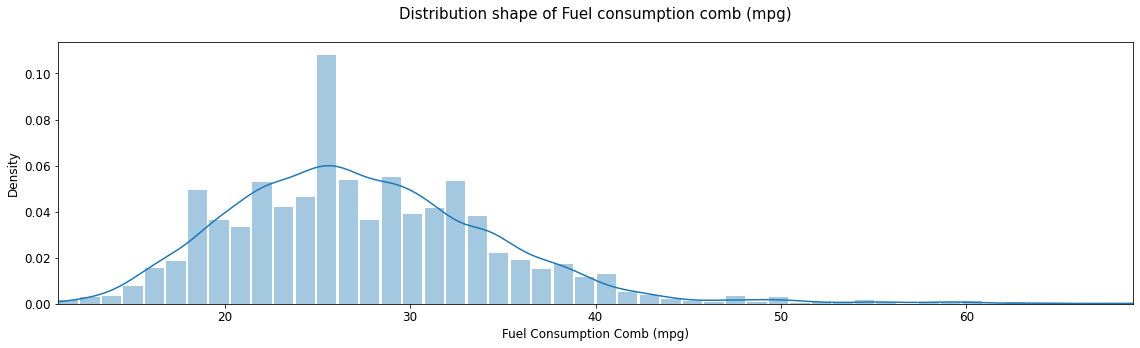

C:\Users\jobis\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


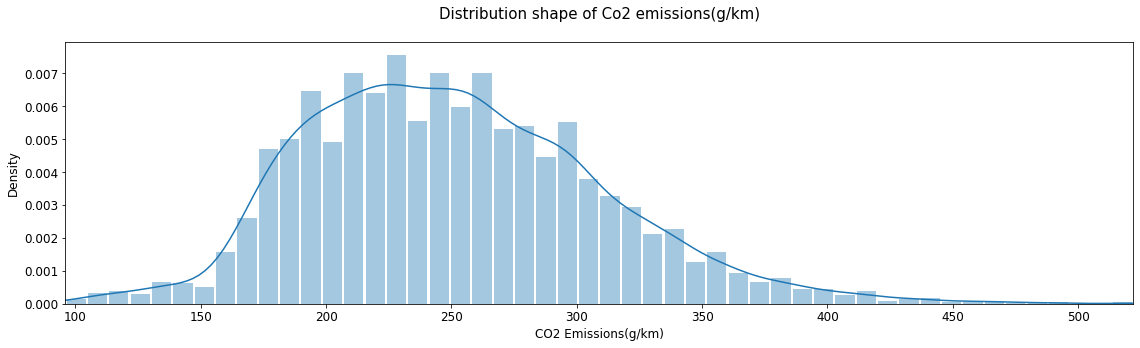

C:\Users\jobis\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


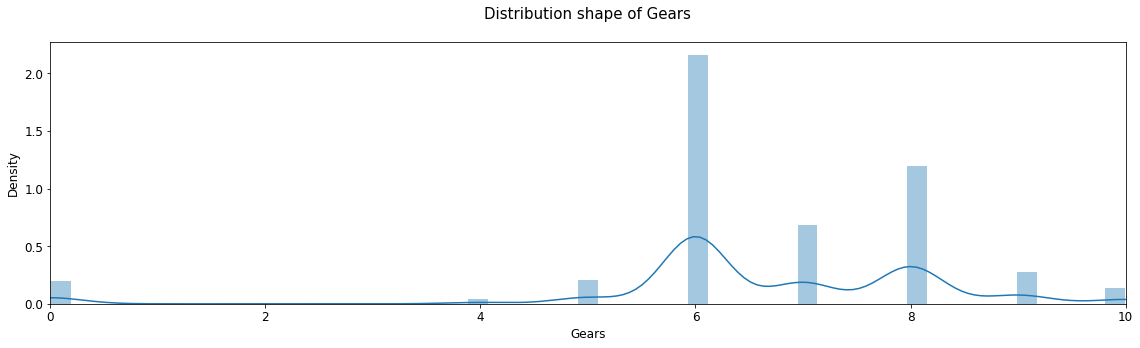

In [131]:
#Distribution and skewness of each feature
for feature in df.select_dtypes("number").columns:
    
    plt.figure(figsize=(16,5))
    sns.distplot(df[feature], hist_kws={"rwidth": 0.9})
    plt.xlim(df[feature].min(), df[feature].max())
    plt.title(f"Distribution shape of {feature.capitalize()}\n", fontsize=15)
    plt.tight_layout()
    plt.show()

In [132]:
# Count of categorical data and Mean of CO2 for each category
cat_cols = df.select_dtypes(include=object).columns.tolist()
for col in cat_cols:
    print(col)
    print(df.groupby(col).agg({'CO2 Emissions(g/km)': [np.mean, 'count']}))


Make
              CO2 Emissions(g/km)      
                             mean count
Make                                   
ACURA                  223.652778    72
ALFA ROMEO             224.900000    30
ASTON MARTIN           339.617021    47
AUDI                   250.846154   286
BENTLEY                362.934783    46
BMW                    254.007590   527
BUGATTI                522.000000     3
BUICK                  233.058252   103
CADILLAC               265.854430   158
CHEVROLET              264.346939   588
CHRYSLER               246.170455    88
DODGE                  276.361789   246
FIAT                   192.246575    73
FORD                   260.988854   628
GENESIS                284.840000    25
GMC                    299.917683   328
HONDA                  190.219626   214
HYUNDAI                208.871429   210
INFINITI               254.064815   108
JAGUAR                 267.987500   160
JEEP                   250.342629   251
KIA                    214.294372  

In [133]:
# Find index of fuel type = Natural Gas
df_N=df[df["Fuel Type"]=="N"]
indexs=df_N.index
df_N

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Gears
2439,CHEVROLET,IMPALA DUAL FUEL,MID-SIZE,3.6,6,AS,N,15.2,9.5,12.7,22,213,6


In [134]:
# Remove fuel Type N(Only One data)
for i in indexs:
    df.drop(i, axis = 0,inplace = True)

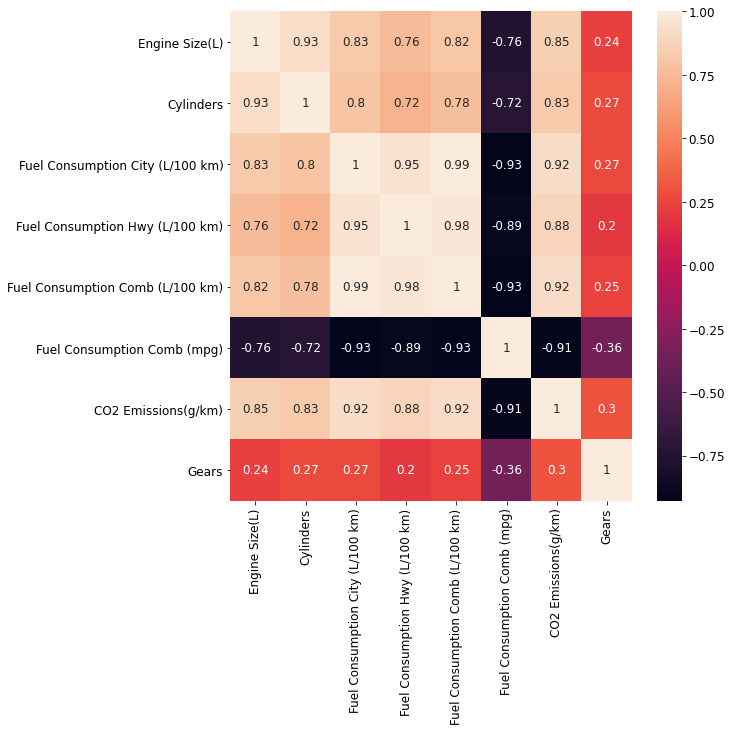

In [135]:
sns.heatmap(df.corr(), annot=True)
plt.show()

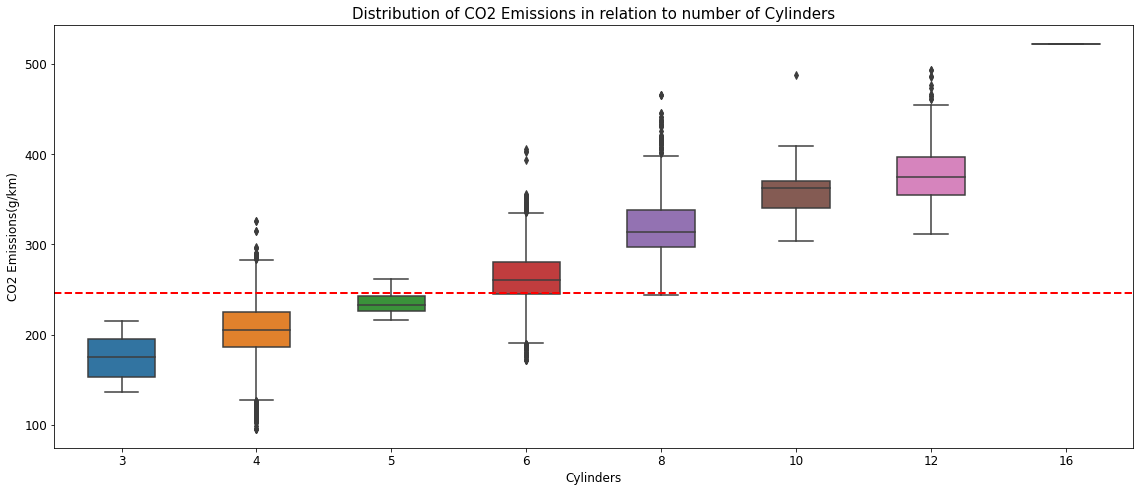

In [136]:
#Distribution of CO2 Emissions in relation to number of Cylinders
plt.figure(figsize=(16,7))
order = df.groupby("Cylinders")["CO2 Emissions(g/km)"].median().sort_values(ascending=True).index
sns.boxplot(x="Cylinders", y="CO2 Emissions(g/km)", data=df, order=order, width=0.5)
plt.title("Distribution of CO2 Emissions in relation to number of Cylinders", fontsize=15)
plt.xlabel("Cylinders", fontsize=12)
plt.ylabel("CO2 Emissions(g/km)", fontsize=12)
plt.axhline(df["CO2 Emissions(g/km)"].median(),color='r',linestyle='dashed',linewidth=2)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'CO2 Emissions(g/km)')

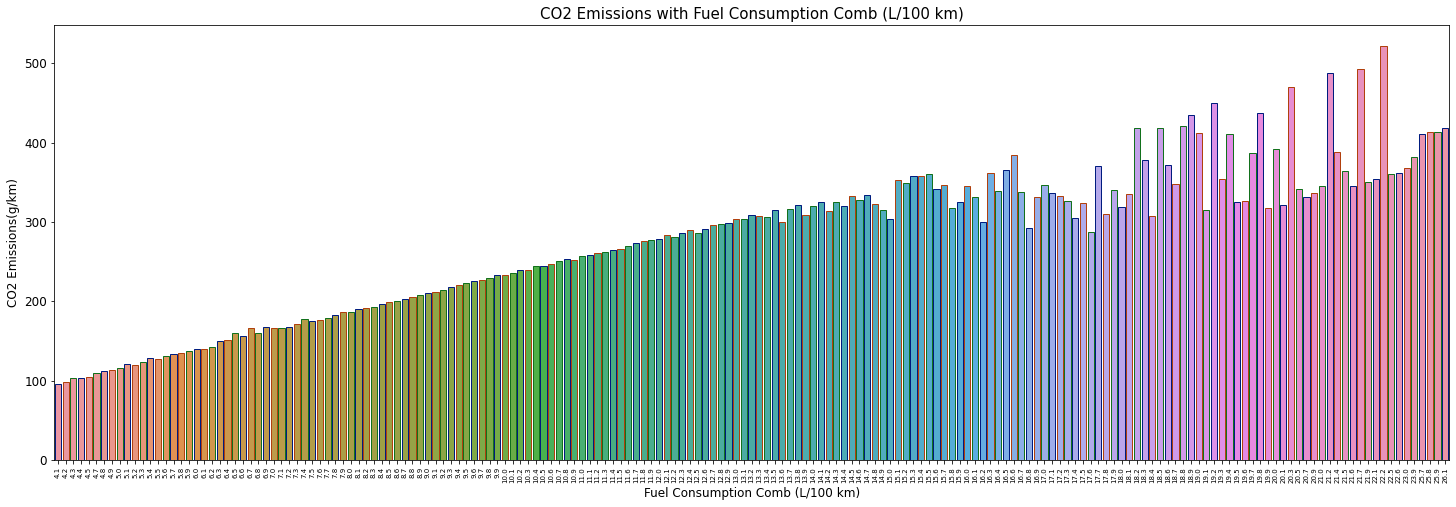

In [137]:
#CO2 Emissions with Fuel Consumption Comb (L/100 km)
CO2_comb = df.groupby(['Fuel Consumption Comb (L/100 km)'])['CO2 Emissions(g/km)'].mean().reset_index()

plt.figure(figsize=(25,8))
sns.barplot(x = "Fuel Consumption Comb (L/100 km)", y="CO2 Emissions(g/km)",data = CO2_comb,
            edgecolor=sns.color_palette("dark", 3))
plt.title('CO2 Emissions with Fuel Consumption Comb (L/100 km)', fontsize=15)
plt.xlabel('Fuel Consumption Comb (L/100 km)', fontsize=12)
plt.xticks(rotation=90, horizontalalignment='center', fontweight='light', fontsize='7')
plt.ylabel('CO2 Emissions(g/km)', fontsize=12)

Text(0, 0.5, 'CO2 Emissions(g/km)')

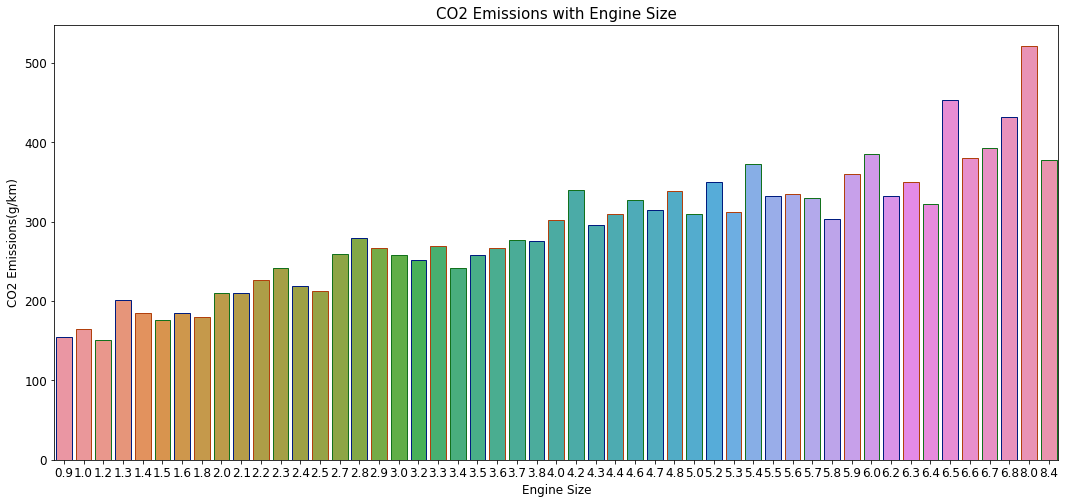

In [138]:
#CO2 Emissions with Engine Size
CO2_engine = df.groupby(['Engine Size(L)'])['CO2 Emissions(g/km)'].mean().reset_index()

plt.figure(figsize=(18,8))
sns.barplot(x = "Engine Size(L)",y="CO2 Emissions(g/km)",data = CO2_engine,
            edgecolor=sns.color_palette("dark", 3))
plt.title('CO2 Emissions with Engine Size', fontsize=15)
plt.xlabel('Engine Size', fontsize=12)
plt.ylabel('CO2 Emissions(g/km)', fontsize=12)

In [139]:
# Remove less important Attributes
df.drop(['Make','Model','Vehicle Class','Fuel Consumption City (L/100 km)','Fuel Consumption Hwy (L/100 km)','Fuel Consumption Comb (mpg)'],inplace=True,axis=1)
df.head()

,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km),Gears
0,2.0,4,AS,Z,8.5,196,5
1,2.4,4,M,Z,9.6,221,6
2,1.5,4,AV,Z,5.9,136,7
3,3.5,6,AS,Z,11.1,255,6
4,3.5,6,AS,Z,10.6,244,6


In [140]:
# One Hot Encoding of Fuel Type
dums = pd.get_dummies(df['Fuel Type'],prefix="Fuel_Type",drop_first=True)
dums.head()

,Fuel_Type_E,Fuel_Type_X,Fuel_Type_Z
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [141]:
frames = [df, dums]
result = pd.concat(frames,axis=1)
result.head()

,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km),Gears,Fuel_Type_E,Fuel_Type_X,Fuel_Type_Z
0,2.0,4,AS,Z,8.5,196,5,0,0,1
1,2.4,4,M,Z,9.6,221,6,0,0,1
2,1.5,4,AV,Z,5.9,136,7,0,0,1
3,3.5,6,AS,Z,11.1,255,6,0,0,1
4,3.5,6,AS,Z,10.6,244,6,0,0,1


In [142]:
#One Hot Encoding of Transmission
dums1 = pd.get_dummies(result['Transmission'],prefix="Transmission",drop_first=True)
dums1.head()

,Transmission_AM,Transmission_AS,Transmission_AV,Transmission_M
0,0,1,0,0
1,0,0,0,1
2,0,0,1,0
3,0,1,0,0
4,0,1,0,0


In [143]:
frames1 = [result, dums1]
preprocessed_data = pd.concat(frames1,axis=1)
preprocessed_data

,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km),Gears,Fuel_Type_E,Fuel_Type_X,Fuel_Type_Z,Transmission_AM,Transmission_AS,Transmission_AV,Transmission_M
0,2.0,4,AS,Z,8.5,196,5,0,0,1,0,1,0,0
1,2.4,4,M,Z,9.6,221,6,0,0,1,0,0,0,1
2,1.5,4,AV,Z,5.9,136,7,0,0,1,0,0,1,0
3,3.5,6,AS,Z,11.1,255,6,0,0,1,0,1,0,0
4,3.5,6,AS,Z,10.6,244,6,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7380,2.0,4,AS,Z,9.4,219,8,0,0,1,0,1,0,0
7381,2.0,4,AS,Z,9.9,232,8,0,0,1,0,1,0,0
7382,2.0,4,AS,Z,10.3,240,8,0,0,1,0,1,0,0
7383,2.0,4,AS,Z,9.9,232,8,0,0,1,0,1,0,0


In [144]:
# Remove Transmission and Fuel type after One Hot Encoding
preprocessed_data.drop(['Transmission', 'Fuel Type'],inplace=True,axis=1)
preprocessed_data.head()

,Engine Size(L),Cylinders,Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km),Gears,Fuel_Type_E,Fuel_Type_X,Fuel_Type_Z,Transmission_AM,Transmission_AS,Transmission_AV,Transmission_M
0,2.0,4,8.5,196,5,0,0,1,0,1,0,0
1,2.4,4,9.6,221,6,0,0,1,0,0,0,1
2,1.5,4,5.9,136,7,0,0,1,0,0,1,0
3,3.5,6,11.1,255,6,0,0,1,0,1,0,0
4,3.5,6,10.6,244,6,0,0,1,0,1,0,0


In [145]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7384 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Engine Size(L)                    7384 non-null   float64
 1   Cylinders                         7384 non-null   int64  
 2   Fuel Consumption Comb (L/100 km)  7384 non-null   float64
 3   CO2 Emissions(g/km)               7384 non-null   int64  
 4   Gears                             7384 non-null   int64  
 5   Fuel_Type_E                       7384 non-null   uint8  
 6   Fuel_Type_X                       7384 non-null   uint8  
 7   Fuel_Type_Z                       7384 non-null   uint8  
 8   Transmission_AM                   7384 non-null   uint8  
 9   Transmission_AS                   7384 non-null   uint8  
 10  Transmission_AV                   7384 non-null   uint8  
 11  Transmission_M                    7384 non-null   uint8  
dtypes: flo

In [146]:
# Rename columns
preprocessed_data.rename(columns = {'Fuel Consumption Comb (L/100 km)' : 'Fuel_Consumption_Comb', 'Engine Size(L)' : 'Engine_Size',  'CO2 Emissions(g/km)' : 'CO2_Emissions'}, inplace = True)

In [147]:
# Correlation of CO2 Emissions with other attributes
most_correlated =preprocessed_data.corr().abs()['CO2_Emissions'].sort_values(ascending=False)
most_correlated


CO2_Emissions            1.000000
Fuel_Consumption_Comb    0.918151
Engine_Size              0.851203
Cylinders                0.832688
Transmission_AV          0.329488
Gears                    0.301536
Fuel_Type_X              0.260492
Fuel_Type_Z              0.231106
Transmission_M           0.166215
Fuel_Type_E              0.096180
Transmission_AS          0.070532
Transmission_AM          0.004563
Name: CO2_Emissions, dtype: float64

In [148]:
# Remove the attribures having less correlation with Co2 Emission
#preprocessed_data.drop(['Fuel_Type_E', 'Transmission_AS', 'Transmission_AM'],inplace=True,axis=1)
preprocessed_data.drop(['Transmission_AM'],inplace=True,axis=1)

In [149]:
preprocessed_data

,Engine_Size,Cylinders,Fuel_Consumption_Comb,CO2_Emissions,Gears,Fuel_Type_E,Fuel_Type_X,Fuel_Type_Z,Transmission_AS,Transmission_AV,Transmission_M
0,2.0,4,8.5,196,5,0,0,1,1,0,0
1,2.4,4,9.6,221,6,0,0,1,0,0,1
2,1.5,4,5.9,136,7,0,0,1,0,1,0
3,3.5,6,11.1,255,6,0,0,1,1,0,0
4,3.5,6,10.6,244,6,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7380,2.0,4,9.4,219,8,0,0,1,1,0,0
7381,2.0,4,9.9,232,8,0,0,1,1,0,0
7382,2.0,4,10.3,240,8,0,0,1,1,0,0
7383,2.0,4,9.9,232,8,0,0,1,1,0,0


In [150]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7384 entries, 0 to 7384
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Engine_Size            7384 non-null   float64
 1   Cylinders              7384 non-null   int64  
 2   Fuel_Consumption_Comb  7384 non-null   float64
 3   CO2_Emissions          7384 non-null   int64  
 4   Gears                  7384 non-null   int64  
 5   Fuel_Type_E            7384 non-null   uint8  
 6   Fuel_Type_X            7384 non-null   uint8  
 7   Fuel_Type_Z            7384 non-null   uint8  
 8   Transmission_AS        7384 non-null   uint8  
 9   Transmission_AV        7384 non-null   uint8  
 10  Transmission_M         7384 non-null   uint8  
dtypes: float64(2), int64(3), uint8(6)
memory usage: 709.4 KB


In [151]:
X = preprocessed_data.drop(['CO2_Emissions'],axis=1)
y = preprocessed_data['CO2_Emissions']
# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [152]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    #model_name_list = ['Linear Regression', 'KNeighbors Regression','Bayesian Ridge Regression']
    model_name_list = ['KNeighbors Regression']
    
    # Instantiate the models
    #model1 = LinearRegression()
    model2 = KNeighborsRegressor(5)
    #model3 = BayesianRidge()
  
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse', 'r2score'], index = model_name_list)
    
    # Train and predict with each model
    #for i, model in enumerate([model1, model2, model3]):
    for i, model in enumerate([ model2]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        #rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        rmse = mean_squared_error(y_test, predictions, squared=False)
        r2score = r2_score(y_test, predictions)
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse, r2score]
    
    return results

In [153]:
results = evaluate(X_train, X_test, y_train, y_test)

In [154]:
# Bayesian Linear Regression
import numpy as np
from scipy import stats

class BayesLinReg:

    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.cov_inv = np.identity(n_features) / alpha

    def learn(self, x, y):

        # Update the inverse covariance matrix 
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)

        # Update the mean vector 
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)

        self.cov_inv = cov_inv
        self.mean = mean

        return self

    def predict(self, x):

        # Obtain the predictive mean 
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance 
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + x @ w_cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

    @property
    def weights_dist(self):
        cov = np.linalg.inv(self.cov_inv)
        return stats.multivariate_normal(mean=self.mean, cov=cov)

In [155]:
model = BayesLinReg(n_features=X_train.shape[1], alpha=.3, beta=1)

for x, y in zip(X_train.values, y_train):
    model.learn(x, y)

y_pred = np.empty(len(X_test))

for i, (x, _) in enumerate(zip(X_test.values, y_test)):
    y_pred[i] = model.predict(x).mean()

mae = metrics.mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2score = r2_score(y_test, y_pred)
print(f"r2 Score Of Test Set : {r2_score(y_test, y_pred)}")
results.loc["Bayesian Linear Regression", :] = [mae, rmse, r2score]

r2 Score Of Test Set : 0.9879641740798586


In [156]:
# Gaussian Process Regression


kernel  = ConstantKernel(7.82**2, (1e-1, 1e3)) * RBF(11.1, (1e-3, 1e3))

# gp_skltest = GaussianProcessRegressor(gp_kernel,
#                                     copy_X_train=False,
#                                     normalize_y=True,
#                                     n_restarts_optimizer=5
#                                     #,optimizer= None
#                                  )

gp_skltest  = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=True, optimizer= None)

In [157]:

gp_skltest.fit(X_train, y_train)
#gp_skltest.fit(X_train[:500], y_train[:500])
predictions = gp_skltest.predict(X_test)

# Metrics
mae = np.mean(abs(predictions - y_test))
#rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
rmse = mean_squared_error(y_test, predictions, squared=False)
r2score = r2_score(y_test, predictions)

# Insert results into the dataframe
results.loc["Gausian Process Regression", :] = [mae, rmse, r2score]
print(r2score)

0.9978313010467603


In [119]:
gp_skltest.log_marginal_likelihood(gp_skltest.kernel_.theta)

973.7320390536106

In [74]:
gp_skltest.kernel_.get_params()

{'k1': 7.82**2,
 'k2': RBF(length_scale=11.1),
 'k1__constant_value': 61.2163991304911,
 'k1__constant_value_bounds': (0.1, 1000.0),
 'k2__length_scale': 11.100978971798964,
 'k2__length_scale_bounds': (0.001, 1000.0)}

In [158]:
results

,mae,rmse,r2score
KNeighbors Regression,3.30803,6.01863,0.989504
Bayesian Linear Regression,3.80682,6.44504,0.987964
Gausian Process Regression,2.11887,2.73582,0.997831


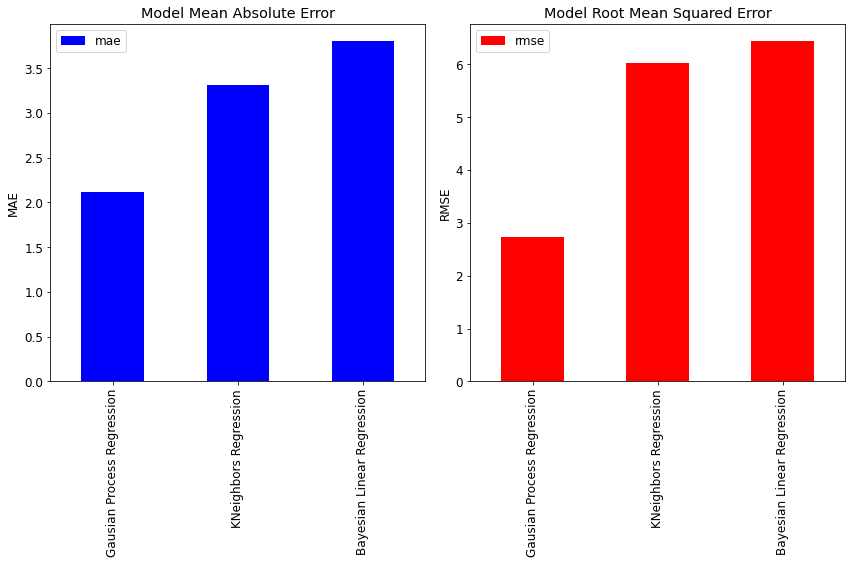

In [121]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 12
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()



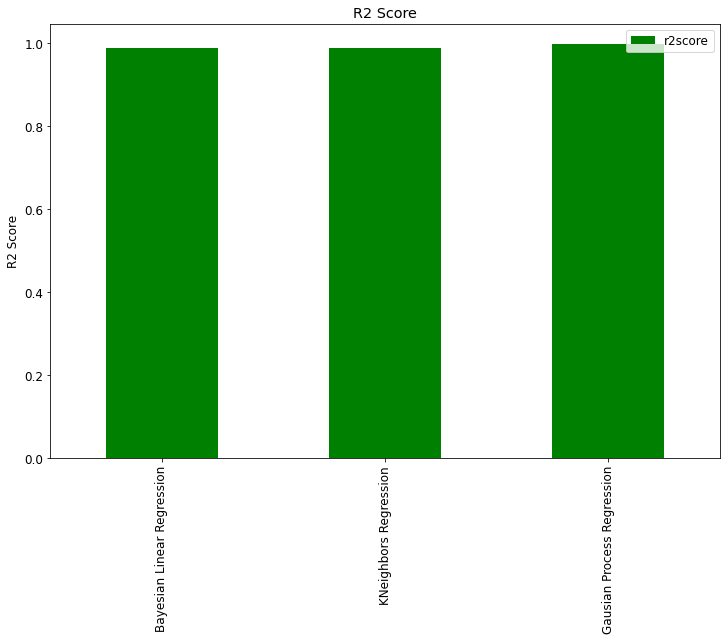

In [122]:
# R2 Score
ax = plt.subplot(1, 1, 1)
results.sort_values('r2score', ascending = True).plot.bar(y = 'r2score', color = 'g', ax = ax)
plt.title('R2 Score'); plt.ylabel('R2 Score');